In [41]:
%load_ext autoreload
%autoreload 

from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.preprocess_ucr import UCRDataset
from preprocessing.preprocess_ucr import AugUCRDataset
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time
from preprocessing.augmentations import TimeFreqAugmenter
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import torch.nn.functional as F
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:


def gamma_func(self, mode="cosine"):
        if mode == "linear":
            return lambda r: 1 - r
        elif mode == "cosine":
            return lambda r: np.cos(r * np.pi / 2)
        elif mode == "square":
            return lambda r: 1 - r**2
        elif mode == "cubic":
            return lambda r: 1 - r**3

(array([ 19.,   0.,  18.,   0.,   0.,  10.,   0.,  10.,   0.,   0.,  19.,
          0.,   0.,  20.,   0.,  27.,   0.,   0.,  16.,   0.,   0.,  18.,
          0.,  22.,   0.,   0.,  23.,   0.,  16.,   0.,   0.,  13.,   0.,
          0.,  21.,   0.,  21.,   0.,   0.,  18.,   0.,   0.,  14.,   0.,
         17.,   0.,   0.,  14.,   0.,   0.,  21.,   0.,  31.,   0.,   0.,
         29.,   0.,  15.,   0.,   0.,  16.,   0.,   0.,  20.,   0.,  24.,
          0.,   0.,  27.,   0.,   0.,  22.,   0.,  26.,   0.,   0.,  26.,
          0.,  21.,   0.,   0.,  25.,   0.,   0.,  40.,   0.,  31.,   0.,
          0.,  34.,   0.,   0.,  42.,   0.,  45.,   0.,   0.,  48.,   0.,
        121.]),
 array([ 0.  ,  0.38,  0.76,  1.14,  1.52,  1.9 ,  2.28,  2.66,  3.04,
         3.42,  3.8 ,  4.18,  4.56,  4.94,  5.32,  5.7 ,  6.08,  6.46,
         6.84,  7.22,  7.6 ,  7.98,  8.36,  8.74,  9.12,  9.5 ,  9.88,
        10.26, 10.64, 11.02, 11.4 , 11.78, 12.16, 12.54, 12.92, 13.3 ,
        13.68, 14.06, 14.44, 14.82

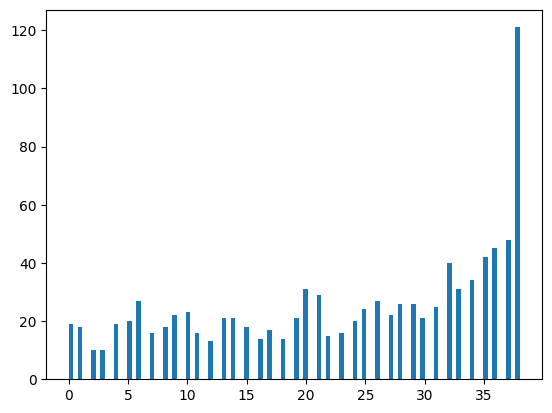

In [69]:
# randomly sample `t`
gamma = gamma_func("cosine")
device = "cuda"
s = torch.randint(0, 30, (256, 40, 64), dtype=torch.float32)

ns = []
for i in range(1000):
    t = np.random.uniform(0, 1)
    # create masks
    n_masks = math.floor(gamma(t) * (s.shape[1]-1))
    if n_masks == 40:
        print("ok")
    ns.append(n_masks)

plt.hist(ns, bins=100)

In [54]:
config = load_yaml_param_settings("configs/config.yaml")

# config['dataset']['dataset_name'] = 'Wafer'

# data pipeline
dataset_importer = UCRDatasetImporter(**config["dataset"])
batch_size = config["dataset"]["batch_sizes"]["stage1"]
train_data_loader = build_data_pipeline(
    batch_size, dataset_importer, config, "train", augment=True
)
test_data_loader = build_data_pipeline(batch_size, dataset_importer, config, "test")

augmenter = TimeFreqAugmenter(**config["augmentations"]["aug_params"])

self.X_train.shape: (1000, 1024)
self.X_test.shape: (8236, 1024)
# unique labels (train): [0 1 2]
# unique labels (test): [0 1 2]


In [19]:
dataset_importer = UCRDatasetImporter(**config["dataset"])

X_train = dataset_importer.X_train[:, None, :]
X_test = dataset_importer.X_test[:, None, :]

self.X_train.shape: (1000, 1024)
self.X_test.shape: (8236, 1024)
# unique labels (train): [0 1 2]
# unique labels (test): [0 1 2]


In [87]:
def adaptive_pooling(z, proj_in):
    # Pools adaptively to a dimension suitable for the projector input dimension.
    # May only work for 3D tensors. So during prior learning.
    z_avg_pooled = F.adaptive_avg_pool2d(
        z, (1, proj_in // 2)
    )  # (B, C, H) --> (B, 1, dim/2=H)
    z_max_pooled = F.adaptive_max_pool2d(
        z, (1, proj_in // 2)
    )  # (B, C, H) --> (B, 1, dim/2=H)
    z_global = torch.cat(
        (z_avg_pooled.squeeze(1), z_max_pooled.squeeze(1)), dim=1
    )  # (B, 2H=dim)

    return z_global

def pooling(z, p):
    if len(z.size()) ==  3:
        z = z.unsqueeze(-1)

    z_avg_pooled = F.adaptive_avg_pool2d(z, (1, 1)) # (B, C, 1, 1)
    z_max_pooled = F.adaptive_max_pool2d(z, (1, 1))

    z_avg_pooled.squeeze(-1).squeeze(-1)
    z_max_pooled.squeeze(-1).squeeze(-1)

    z_global = torch.cat((z_avg_pooled, z_max_pooled), dim=1)  # (B, 2C)
    return z_global    

z1 = torch.randn(256, 2, 64)
z2 = adaptive_pooling(z1, 2*40)
print(z2.shape)


torch.Size([256, 80])


In [81]:

    
z = torch.randn(256, 64, 4, 8)
z_avg_pooled = F.adaptive_avg_pool2d(z, (1, 1))
z_avg_pooled = z_avg_pooled.squeeze(-1).squeeze(-1)
print(z_avg_pooled.shape)
#z_avg_pooled

torch.Size([256, 64])


In [68]:
len(z1.size())

3

In [69]:
def adaptive_pool(z, p):
    # Pools adaptively to a dimension suitable for the projector input dimension.
    if len(z.size()) ==  3:
        z = z.unsqueeze(-1)

    z_avg_pooled = F.adaptive_avg_pool2d(z, (1, 1)) # (B, C, 1, 1)
    z_max_pooled = F.adaptive_max_pool2d(z, (1, 1))

    return z_avg_pooled, z_max_pooled

z = torch.randn(256, 64, 4, 8)
z2 = torch.randn(256, 40, 64)

a, b = adaptive_pool(z, 2*64)
print(a.shape, b.shape)

torch.Size([256, 64, 1, 1]) torch.Size([256, 64, 1, 1])


In [60]:
z = torch.randn(256, 40, 64)
z = z.unsqueeze(-1)  # Add an extra dimension
z_avg_pooled = F.adaptive_avg_pool2d(z, (1, 1))
z_avg_pooled = z_avg_pooled.squeeze(-1).squeeze(-1)  # Remove the extra dimensions
print(z_avg_pooled.shape)

torch.Size([256, 40])


In [44]:
def adaptive_pooling2(z, proj_in):
    # Pools adaptively to a dimension suitable for the projector input dimension.

    # Reshape z to (B, C*H, W, 1)
    z = z.view(z.shape[0], -1, z.shape[3], 1)

    z_avg_pooled = F.adaptive_avg_pool2d(
        z, (proj_in // 2, 1)
    )  # (B, C*H, W, 1) --> (B, proj_in // 2, 1, 1)
    z_max_pooled = F.adaptive_max_pool2d(
        z, (proj_in // 2, 1)
    )  # (B, C*H, W, 1) --> (B, proj_in // 2, 1, 1)

    z_global = torch.cat(
        (z_avg_pooled.squeeze(-1).squeeze(-1), z_max_pooled.squeeze(-1).squeeze(-1)), dim=1
    )  # (B, 2 * (proj_in // 2))

    return z_global

z1 = torch.randn(256, 64, 5, 8)
z2 = adaptive_pooling2(z1, 2*64)
print(z2.shape)

torch.Size([256, 640, 64])


In [22]:
def get_x_u():
    X = torch.tensor(train_data_loader.dataset.X)
    x = X[np.random.randint(0, X.shape[0])]
    return x, augmenter.stft(x)


def plot(x, xaug, u, uaug):
    f, a = plt.subplots(1, 3, figsize=(15, 5))

    # Visualize the magnitude of the original and augmented STFT representations
    a[0].imshow(np.abs(u), aspect="auto", cmap="viridis")  # You can adjust the cmap
    a[1].imshow(np.abs(uaug), aspect="auto", cmap="viridis")  # You can adjust the cmap

    # Plot the original and augmented signals
    a[2].plot(x, label="original")
    a[2].plot(xaug, label="augmented")  # Include the augmented signal in the plot
    a[2].legend()

    plt.show()

# Random Block Augmentation


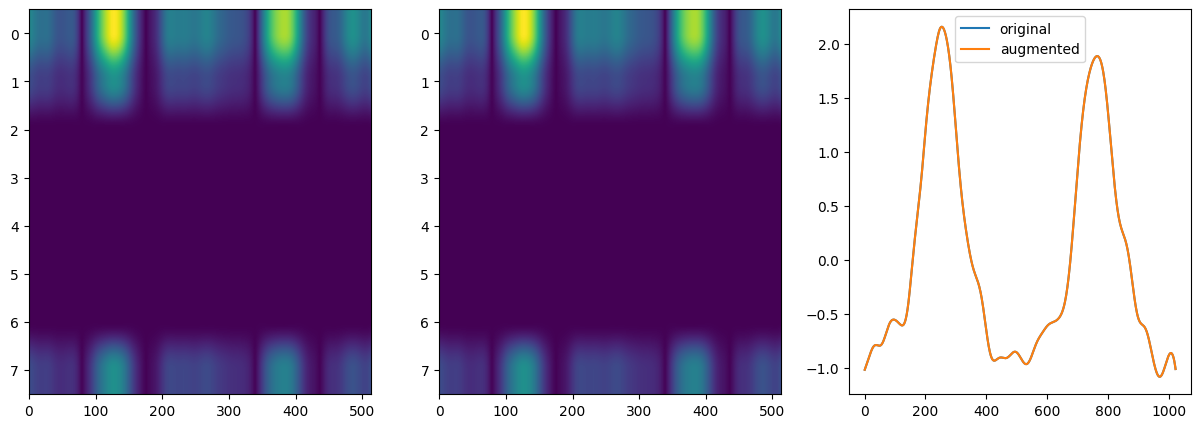

torch.Size([1024]) torch.Size([1024]) torch.Size([8, 513]) (8, 513)


In [41]:
x, u = get_x_u()

augmenter.update_parameters(block_size_scale=0.1, block_density=0.1)

# Apply block augmentation to the complex-valued u directly
uaug_blocks = augmenter.add_block_augmentation(u.numpy())

# Convert the augmented u back to the time domain
xaug_block = augmenter.istft(torch.from_numpy(uaug_blocks), x.shape[0])

plot(x, xaug_block, u, uaug_blocks)
print(x.shape, xaug_block.shape, u.shape, uaug_blocks.shape)

# Random band augmentation


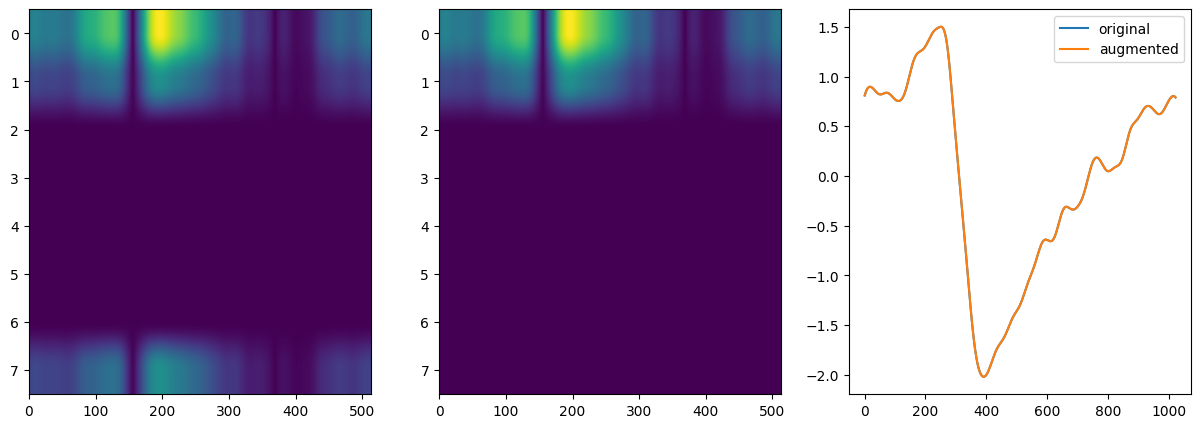

torch.Size([1024]) torch.Size([1024]) torch.Size([8, 513]) (8, 513)


In [43]:
x, u = get_x_u()

augmenter.update_parameters(num_bands_to_remove=2, band_scale_factor=0.15)

# Apply block augmentation to the complex-valued u directly
uaug_band = augmenter.add_band_augmentation(u.numpy())
xaug_band = augmenter.istft(torch.from_numpy(uaug_band), x.shape[0])

plot(x, xaug_band, u, uaug_band)
print(x.shape, xaug_band.shape, u.shape, uaug_band.shape)

# Random Phase Augmentation


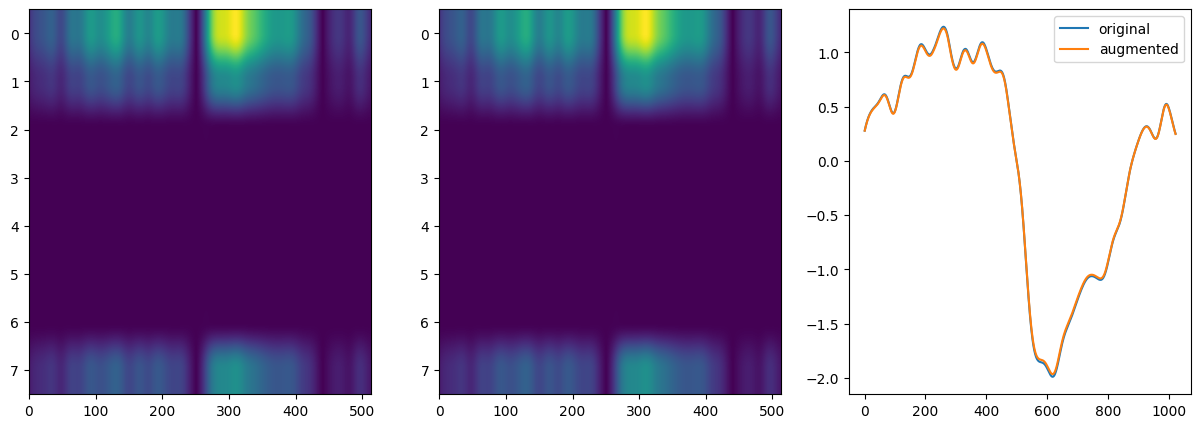

In [44]:
x, u = get_x_u()

augmenter.update_parameters(phase_max_change=np.pi / 4)

uaug_phase = augmenter.add_phase_augmentation(u.numpy())
xaug_phase = augmenter.istft(torch.from_numpy(uaug_phase), x.shape[0])

plot(x, xaug_phase, u, uaug_phase)

# Random Rotation Augmentation


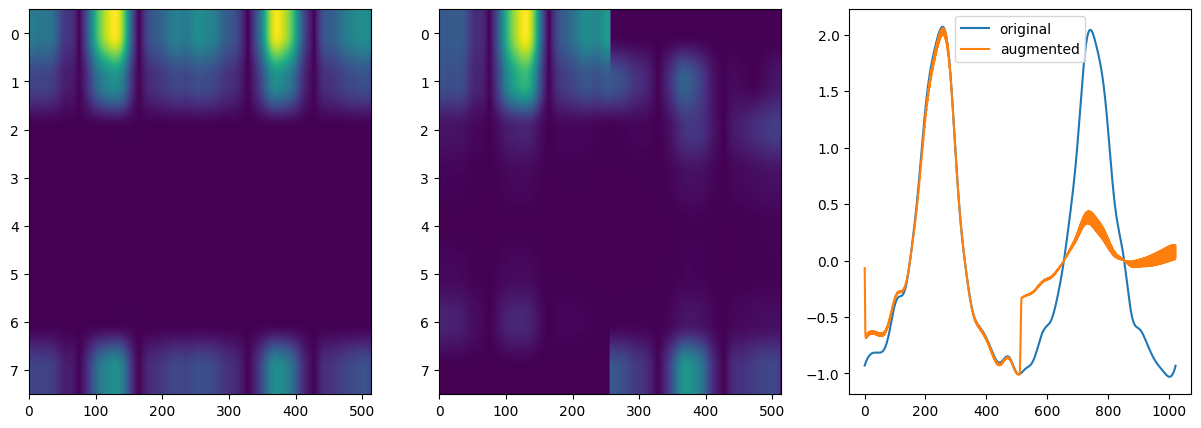

In [45]:
x, u = get_x_u()

augmenter.update_parameters(rotation_max_change=30)

uaug_rotation = augmenter.add_rotation_augmentation(u.numpy())
xaug_rotation = augmenter.istft(torch.from_numpy(uaug_rotation), x.shape[0])

plot(x, xaug_rotation, u, uaug_rotation)

# Gaussian augmentation


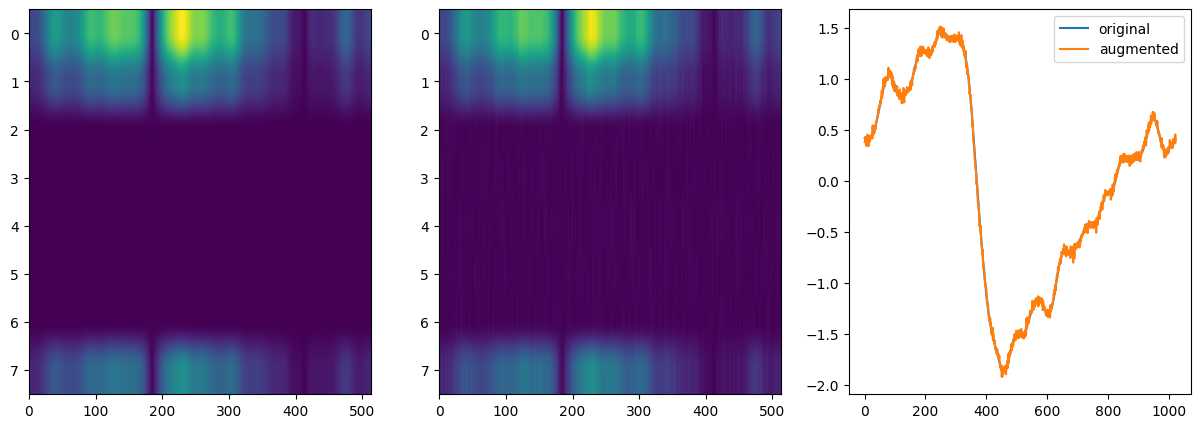

In [46]:
x, u = get_x_u()

augmenter.update_parameters(gaus_mean=0, gaus_std=0.1)

uaug_gaus = augmenter.add_gaussian_augmentation(u.numpy())
xaug_gaus = augmenter.istft(torch.from_numpy(uaug_gaus), x.shape[0])

plot(x, xaug_gaus, u, uaug_gaus)

# Random scaling


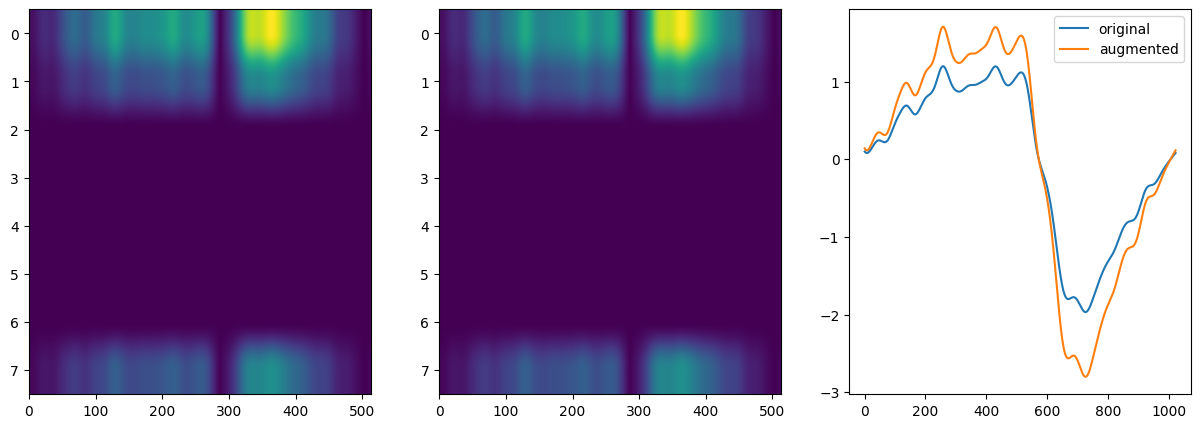

In [47]:
x, u = get_x_u()

augmenter.update_parameters(min_scale=0.5, max_scale=1.5)

uaug_scale = augmenter.add_scale_augmentation(u.numpy())
xaug_scale = augmenter.istft(torch.from_numpy(uaug_scale), x.shape[0])

plot(x, xaug_scale, u, uaug_scale)

# Random masks


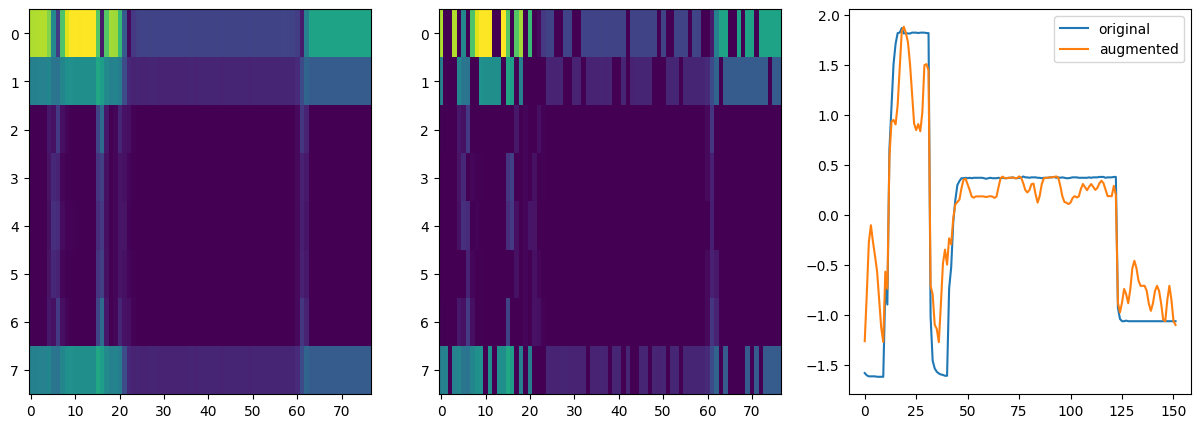

In [47]:
x, u = get_x_u()

augmenter.update_parameters(mask_density=0.3)

uaug_mask = augmenter.add_random_masks_augmentation(u.numpy())
xaug_mask = augmenter.istft(torch.from_numpy(uaug_mask), x.shape[0])

plot(x, xaug_mask, u, uaug_mask)

# Shear Augmentation


torch.Size([8, 77])


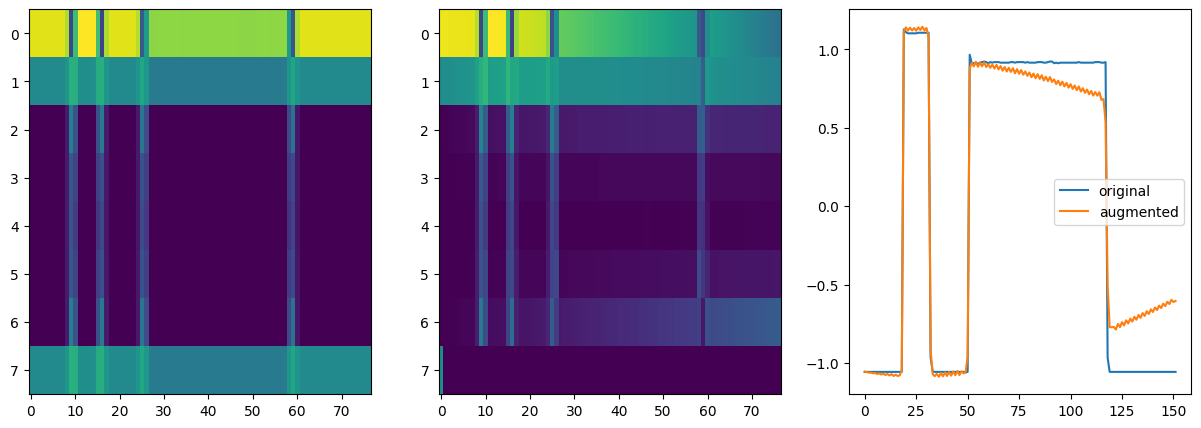

In [14]:
x, u = get_x_u()

print(u.shape)

augmenter.update_parameters(max_shear_x=0.01, max_shear_y=0.01)

uaug_shear = augmenter.add_shear_augmentation(u.numpy())
xaug_shear = augmenter.istft(torch.from_numpy(uaug_shear), x.shape[0])

plot(x, xaug_shear, u, uaug_shear)

# Random Combination Augmentation


['slope', 'noise_window', 'phase', 'gaussian', 'scale']


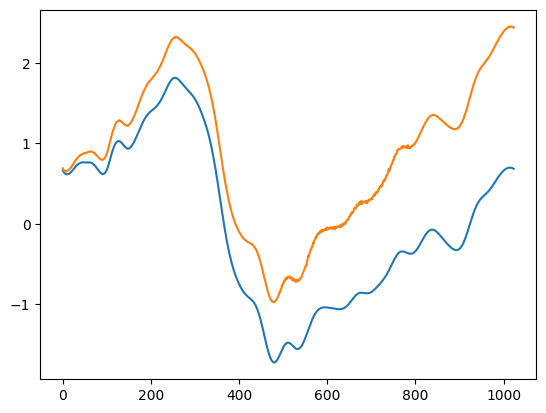

In [35]:
from preprocessing.augmentations import Augmenter

config = load_yaml_param_settings("configs/config.yaml")

aug = Augmenter(**config["augmentations"])

x, u = get_x_u()
xaug, combination = aug.augment(x, return_combinations=True)

print(combination)
plt.plot(x)
plt.plot(xaug)

In [3]:
from preprocessing.preprocess_ucr import UCRDatasetImporter

importer = UCRDatasetImporter("ECG5000", data_scaling=True)

self.X_train.shape: (500, 140)
self.X_test.shape: (4500, 140)
# unique labels (train): [0 1 2 3 4]
# unique labels (test): [0 1 2 3 4]


In [4]:
X_tr = importer.X_train

In [2]:
import torch
import torch.nn.functional as F

# Given token embeddings and masks
device = "cuda"
token_emb = torch.rand(
    (2, 5, 4), device=device
)  # Batch size of 2, sequence length of 5, embedding size of 4
masks = torch.tensor(
    [
        [False, True, False, True, False],  # First sequence mask
        [False, False, True, False, True],  # Second sequence mask
    ]
)

# extract unmasked tokens
# unmasked_tokens = torch.from_numpy(np.array([token_emb[i, ~masks[i]].tolist() for i in range(token_emb.shape[0])])

l = [token_emb[i, ~masks[i]].tolist() for i in range(token_emb.shape[0])]
l = torch.tensor(l, device=device)
# print(unmasked_tokens.shape)
# print(token_emb)
# print(masks)
# print(unmasked_tokens)
token_emb.shape

torch.Size([2, 5, 4])

In [4]:
import torch
import numpy as np
import math

In [12]:
# Example usage:
token_emb = torch.rand((2, 5, 4))
masks = torch.tensor(
    [[False, True, False, True, False], [False, False, True, True, True]]
)
print(masks.shape)
n_masks = sum(masks.sum(dim=1))
masks = masks.unsqueeze(-1).expand(token_emb.shape)
summary = torch.ones((2, 5)) * 69

torch.Size([2, 5])


In [10]:
from scipy.stats import truncnorm
import torch
import numpy as np

device = "cuda"

s_M = torch.ones(256, 40)
# sample a masking ratio from a truncated Gaussian distribution
mask_ratio_mu = 0.55
mask_ratio_std = 0.25
mask_ratio_min = 0.5
mask_ratio_max = 1
mask_ratio_generator = truncnorm((mask_ratio_min - mask_ratio_mu) / mask_ratio_std,
                                            (mask_ratio_max - mask_ratio_mu) / mask_ratio_std,
                                            loc=mask_ratio_mu, scale=mask_ratio_std)

drop_rate = 0.5

# calculate the number of tokens to mask and to drop
bsz, seq_len = s_M.size()

n_masks = int(np.ceil(mask_rate * seq_len))
n_drops = int(np.ceil(drop_rate * seq_len))

print(n_drops, n_masks)

while True:
    noise = torch.rand(s_M.shape)  # (b n)
    sorted_noise, _ = torch.sort(noise, dim=1)

    cutoff_drop = sorted_noise[:, n_drops - 1 : n_drops]
    cutoff_mask = sorted_noise[:, n_masks - 1 : n_masks]
    print(cutoff_drop[0], cutoff_mask[0])

    token_drop_mask = (noise <= cutoff_drop).float()
    token_all_mask = (noise <= cutoff_mask).float()
    if (
        token_drop_mask.sum() == bsz * n_drops
        and token_all_mask.sum() == bsz * n_masks
    ):
        break
    else:
        print("whoopsie, universe not happy..")

s_M[token_all_mask.nonzero(as_tuple=True)] = 69

print("s_M masks",torch.sum(s_M == 69, dim=1))
print(torch.sum(token_all_mask == 1, dim=1))

token_keep_mask = 1 - token_all_mask

print("s_M shape", s_M.shape)
s_kept = s_M[(token_keep_mask).nonzero(as_tuple=True)].view(bsz, -1)
s_dropped = s_M[(token_drop_mask).nonzero(as_tuple=True)].view(bsz, -1)
print("s_M kept masks",torch.sum(s_kept== 69, dim=1))
print("s_M kept shape",s_kept.shape)

print("s_M dropped masks",torch.sum(s_dropped== 69, dim=1))
print("s_M dropped shape",s_dropped.shape)


print(torch.sum(token_keep_mask == token_all_mask, dim=1))

#s_M, token_keep_mask, token_all_mask are two dimensional tensors of shape (bsz, seq_len)

# A encoder processes the kept token


20 22
tensor([0.4778]) tensor([0.5105])
s_M masks tensor([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22

In [11]:
mask_ratio_mu = 0.55
mask_ratio_std = 0.25
mask_ratio_min = 0.5
mask_ratio_max = 1
mask_ratio_generator = truncnorm((mask_ratio_min - mask_ratio_mu) / mask_ratio_std,
                                            (mask_ratio_max - mask_ratio_mu) / mask_ratio_std,
                                            loc=mask_ratio_mu, scale=mask_ratio_std)


(array([1442., 1477., 1410., 1436., 1497., 1515., 1451., 1463., 1495.,
        1488., 1435., 1427., 1420., 1404., 1369., 1538., 1526., 1413.,
        1459., 1414., 1417., 1480., 1391., 1440., 1445., 1414., 1320.,
        1436., 1367., 1357., 1309., 1356., 1354., 1325., 1338., 1286.,
        1275., 1303., 1338., 1186., 1256., 1234., 1207., 1175., 1127.,
        1117., 1093., 1108., 1111., 1073., 1090., 1024., 1015.,  993.,
         966., 1005.,  996.,  955.,  894.,  861.,  904.,  821.,  894.,
         871.,  784.,  820.,  753.,  764.,  718.,  685.,  661.,  659.,
         659.,  660.,  636.,  575.,  610.,  584.,  577.,  550.,  547.,
         507.,  559.,  509.,  481.,  428.,  452.,  463.,  419.,  413.,
         440.,  380.,  390.,  369.,  348.,  349.,  327.,  297.,  320.,
         301.]),
 array([0.50000424, 0.50500396, 0.51000367, 0.51500339, 0.52000311,
        0.52500282, 0.53000254, 0.53500226, 0.54000197, 0.54500169,
        0.5500014 , 0.55500112, 0.56000084, 0.56500055, 0.57000027

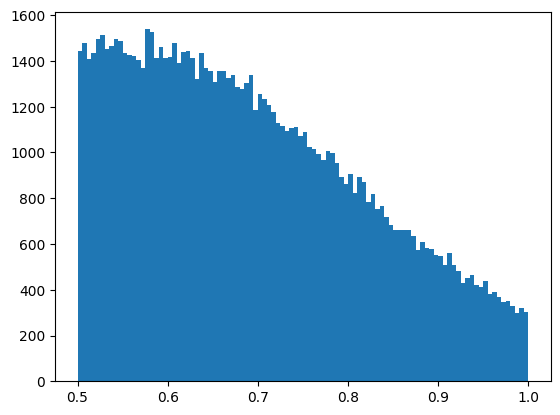

In [15]:
import matplotlib.pyplot as plt
rats = [mask_ratio_generator.rvs(1)[0] for _ in range(100000)]
plt.hist(rats, bins=100)

In [1]:
summary = torch.ones(256, 64) * 69
summary_expanded = summary.unsqueeze(1).expand(-1, token_all_mask.shape[1], -1)
latent = torch.ones(256, s_kept.shape[1], 64) * 420

empty = torch.ones(256, 40, 64) * 69

# Fill empty with summary_expanded
# empty = summary_expanded

padded = summary_expanded.clone()

padded[token_keep_mask.nonzero(as_tuple=True)] = latent.reshape(-1, 64)

print(torch.sum(padded == 420, dim=1))

padded[token_drop_mask.nonzero(as_tuple=True)] = token_emb[
    token_drop_mask.nonzero(as_tuple=True)
]

print(torch.sum(padded == 1, dim=1))

print(torch.sum(padded == 69, dim=1))

NameError: name 'torch' is not defined

In [160]:
summary_expanded = summary.unsqueeze(1).expand(-1, token_all_mask.shape[1], -1)

# Fill empty with summary_expanded
empty = summary_expanded
empty.shape

torch.Size([256, 40, 64])

In [163]:
empty.shape
empty[0][0]

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [11]:
token_emb = torch.ones(256, 40, 64)

latent = torch.ones(256, s_kept.shape[1], 64) * 420
summary = torch.ones(256, 64) * 69

# empty = torch.ones(256, 40, 64) * 2

summary_expanded = summary.unsqueeze(1).expand(-1, token_all_mask.shape[1], -1)

# Fill empty with summary_expanded
padded = summary_expanded.clone()

padded[token_keep_mask.nonzero(as_tuple=True)] = latent.reshape(-1, 64)

padded = torch.where(token_all_mask.unsqueeze(-1).bool(), summary_expanded, padded)

In [13]:
print(torch.sum(padded == 420, dim=1))
print(torch.sum(padded == 69, dim=1))

tensor([[14, 14, 14,  ..., 14, 14, 14],
        [14, 14, 14,  ..., 14, 14, 14],
        [14, 14, 14,  ..., 14, 14, 14],
        ...,
        [14, 14, 14,  ..., 14, 14, 14],
        [14, 14, 14,  ..., 14, 14, 14],
        [14, 14, 14,  ..., 14, 14, 14]])
tensor([[26, 26, 26,  ..., 26, 26, 26],
        [26, 26, 26,  ..., 26, 26, 26],
        [26, 26, 26,  ..., 26, 26, 26],
        ...,
        [26, 26, 26,  ..., 26, 26, 26],
        [26, 26, 26,  ..., 26, 26, 26],
        [26, 26, 26,  ..., 26, 26, 26]])


In [14]:
print(14 / 26)

0.5384615384615384


In [49]:
SSL_weights = {"barlowtwins": 1.0, "vicreg": 0.01}
SSL_weights["barlowtwins"]

1.0